In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [2]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

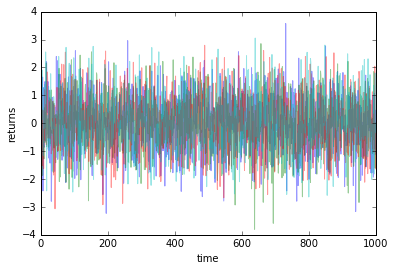

In [3]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [4]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


In [5]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [6]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

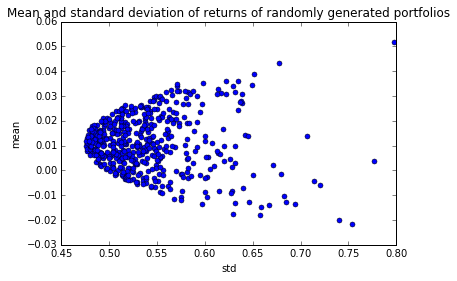

In [7]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

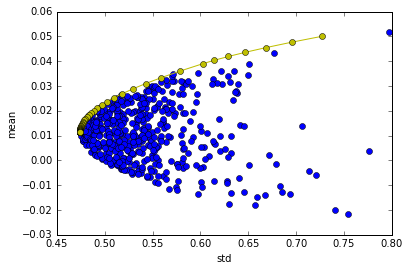

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    # Calculations are performed over 100 days
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [9]:
print weights

[[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


In [10]:
import datetime

import pandas.io.data as web
end = datetime.datetime(2016, 12, 8)
start = end - 120 * pd.tseries.offsets.BDay()


data = web.DataReader(['DEVIX','VSMAX', 'MINJX','TRREX','FIHBX',
                      'CRSOX', 'VSMPX','VAIPX','VWILX','DODGX','DSDYX','VBTIX','VTSNX',
                      'LSSIX','TRBCX',
                      'ODVIX','VMCPX'], 'yahoo', start, end)

/home/tom/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [11]:
data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 118 (major_axis) x 17 (minor_axis)
Items axis: Open to Adj Close
Major_axis axis: 2016-06-23 00:00:00 to 2016-12-08 00:00:00
Minor_axis axis: CRSOX to VWILX

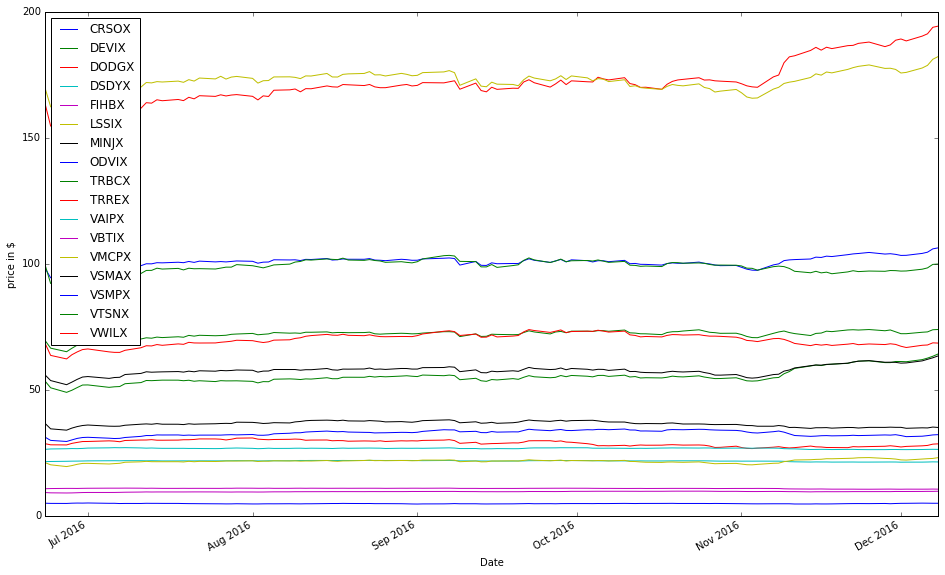

In [12]:
data.loc['Adj Close', :, :].plot(figsize=(16,10))
plt.ylabel('price in $')

In [13]:
closedf = np.log(data.loc['Adj Close', :, :])
pricedf = (closedf.ix[-20] - closedf.ix[0]) 
pricedf = pricedf.dropna()
pricedf

CRSOX   -0.044273
DEVIX    0.070464
DODGX    0.109953
DSDYX   -0.000463
FIHBX    0.037562
LSSIX    0.033492
MINJX   -0.042631
ODVIX    0.042933
TRBCX    0.046102
TRREX   -0.060069
VAIPX    0.007905
VBTIX   -0.006699
VMCPX    0.015689
VSMAX    0.035977
VSMPX    0.035060
VTSNX   -0.011134
VWILX    0.015106
dtype: float64

In [14]:
#  Identify stocks that would be good for trend following on long side    
def screen_funds(data):  


    
    # convert data Panel into dataframe with just close prices
    closedf = np.log(data.loc['Adj Close', :, :])
    pricedf = (closedf.ix[-20] - closedf.ix[0]) 
    pricedf = pricedf.dropna()
    
    # drop rows that don't meet a minimum return over the timeframe -- 1%
    pricedf = pricedf.drop(pricedf[pricedf < 0.01].index)
    
    ranked_secs = sorted(pricedf.index, key=lambda x: pricedf[x], reverse=True)
    
    # Return top five momentum funds
    return ranked_secs[0:5], pricedf
 

In [15]:
top_momentum_funds, pricedf = screen_funds(data)
top_momentum_funds

['DODGX', 'DEVIX', 'TRBCX', 'ODVIX', 'FIHBX']

In [16]:
pricedf

DEVIX    0.070464
DODGX    0.109953
FIHBX    0.037562
LSSIX    0.033492
ODVIX    0.042933
TRBCX    0.046102
VMCPX    0.015689
VSMAX    0.035977
VSMPX    0.035060
VWILX    0.015106
dtype: float64

In [19]:


end = datetime.datetime(2016, 12, 8)
start = end - 150 * pd.tseries.offsets.BDay()


data = web.DataReader(top_momentum_funds, 'yahoo', start, end)

prices = np.log(data.loc['Adj Close', :, :])

# pct_change() returns dataframe of % change from one day to next.
returns = prices.pct_change().dropna()
    
if len(returns.T) > 1:
    # Perform Markowitz-style portfolio optimization
    weights, _, _ = optimal_portfolio(returns.T)
else:
    # only one stock eligible -- take a 10% stake
    weights = np.array([0.1])


In [20]:
weights


array([[  9.99975289e-01],
       [  1.03533701e-05],
       [  6.81336269e-06],
       [  3.80216261e-06],
       [  3.74236755e-06]])